In [1]:
import numpy as np 
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray
# root = '/tigress/cw55/work/2022_radi_nn/NN_AM4'
# path.insert(1,  root)
# path.insert(1,  root+'/work')
# # import work.lw_csaf_Li5Relu_EN.train_script01 as lwcsafen
# import lw_csaf_Li5Relu_EY.train_script01 as lwcsafey 
# # import work.lw_af_Li5Relu_EN.train_script01 as lwafen
# import lw_af_Li5Relu_EY.train_script01 as lwafey 

In [3]:
plt.rcParams['font.size'] = '6'

In [4]:
file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_test2000s_nn_stellarcpu_intelmpi_22_768PE/'
ds = xr.open_dataset(file_path+'POSTP/20000101.atmos_8xdaily.nc') 
ds = ds.rename({'grid_yt':'lat','grid_xt':'lon'})

In [5]:
def plot_var12_diff(var1,level = np.arange(0,300,10), dlevel = np.arange(-10,10.1,0.5)):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
    axs = axs.flatten()
    for i in range(2):
        ax=axs[i]
        da = ds[var1[i]].mean('time').load()
        da.plot(ax=ax, levels=level, extend='both') 
        ax.set_title(f'{var1[i]} GM: {global_mean_xarray(da).values:4.2f}')  
    ax=axs[2]
    da = (ds[var1[0]].mean('time')-ds[var1[1]].mean('time')).load()
    da.plot(ax=ax, levels=dlevel, extend='both') 
    ax.set_title(f'diff GM: {global_mean_xarray(da).values:4.2f}')  
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    fig.tight_layout()  

# OLR Clear- and All-sky 

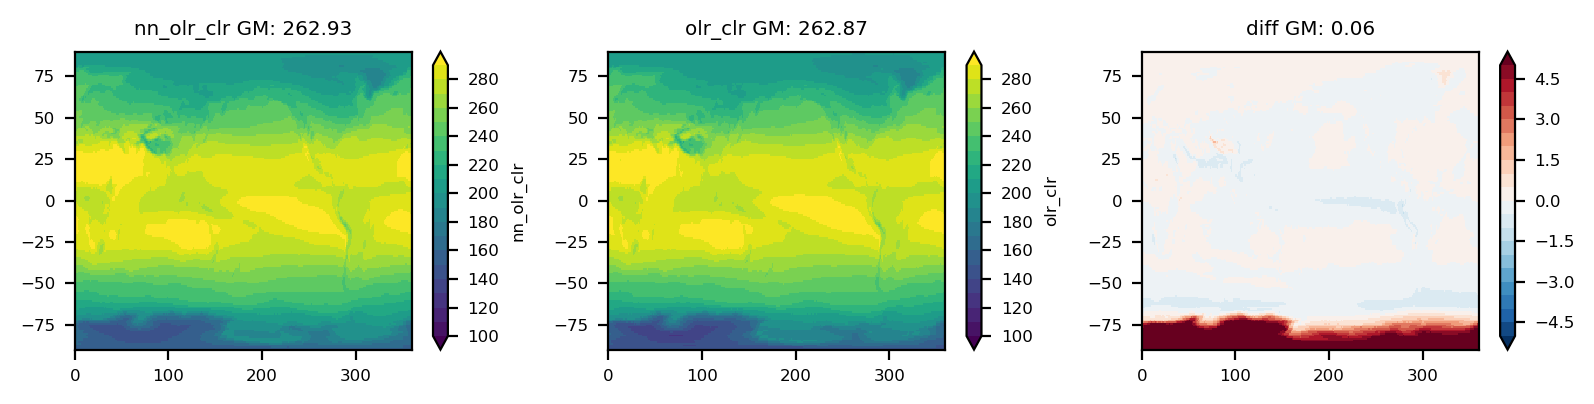

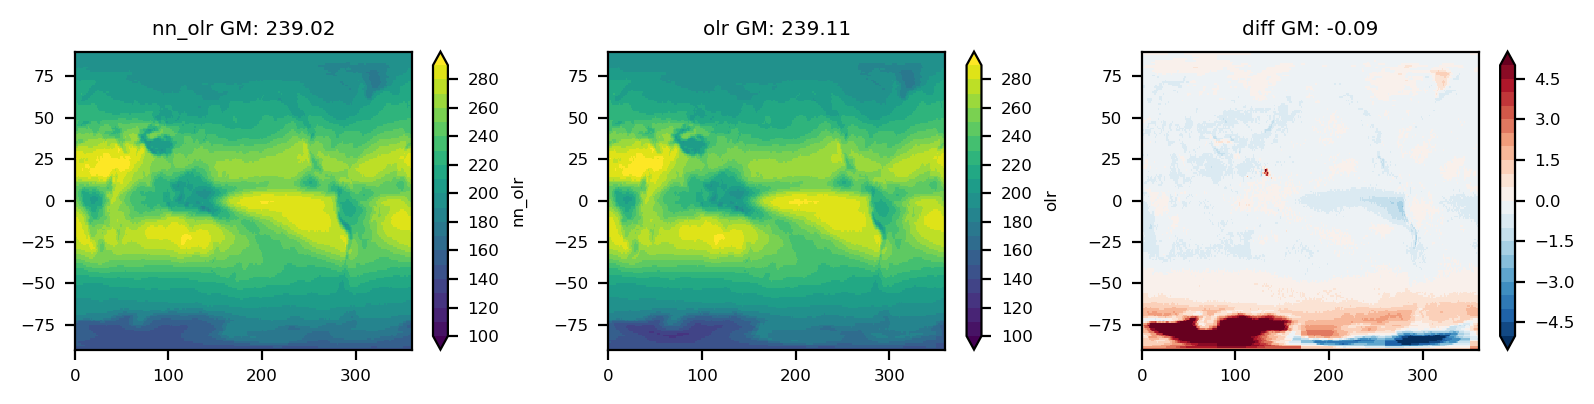

In [6]:
var = ['nn_olr_clr','olr_clr',]
plot_var12_diff(var,level = np.arange(100,300,10), dlevel = np.arange(-5,5.1,0.5))

var = ['nn_olr','olr',]
plot_var12_diff(var,level = np.arange(100,300,10), dlevel = np.arange(-5,5.1,0.5))

# rsut Clear- and All-sky 

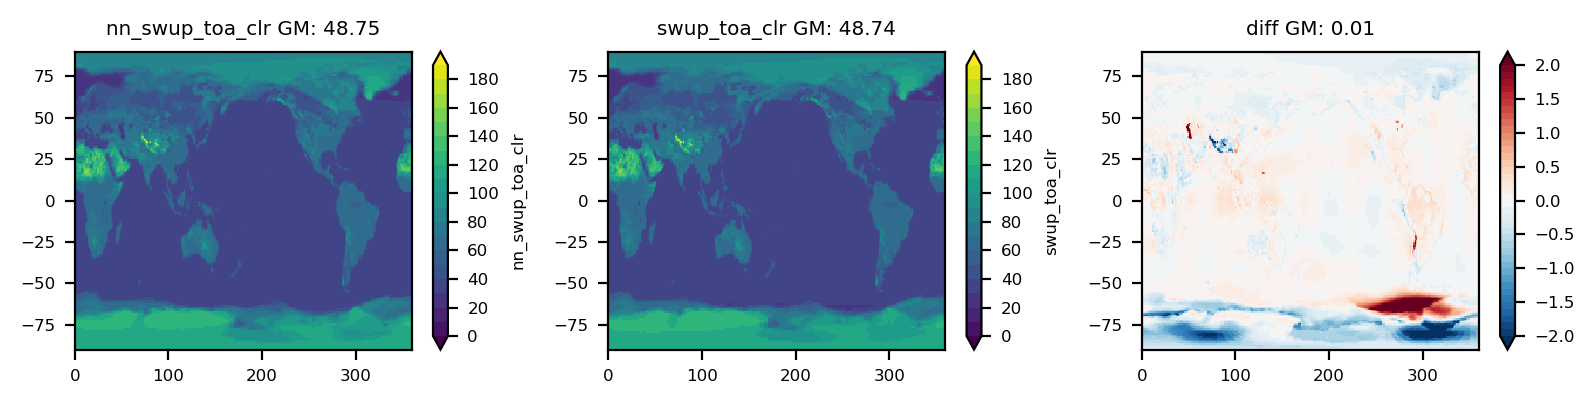

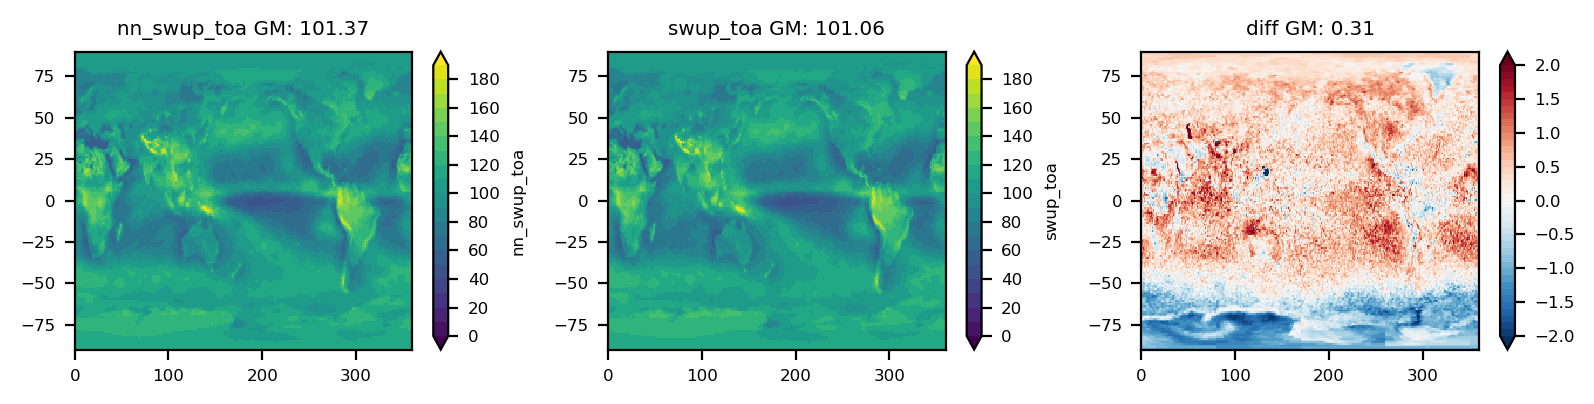

In [7]:
var = ['nn_swup_toa_clr','swup_toa_clr',]
plot_var12_diff(var,level = np.arange(0,200,10), dlevel = np.arange(-2,2.01,0.1))
var = ['nn_swup_toa','swup_toa',]
plot_var12_diff(var,level = np.arange(0,200,10), dlevel = np.arange(-2,2.01,0.1))

# rsds Clear- and All-sky 

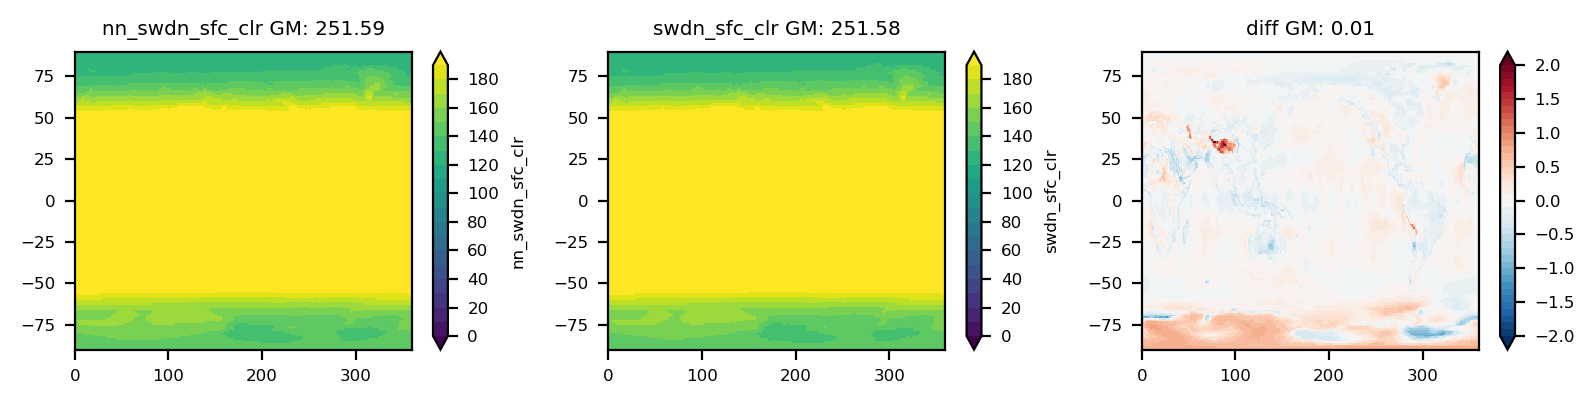

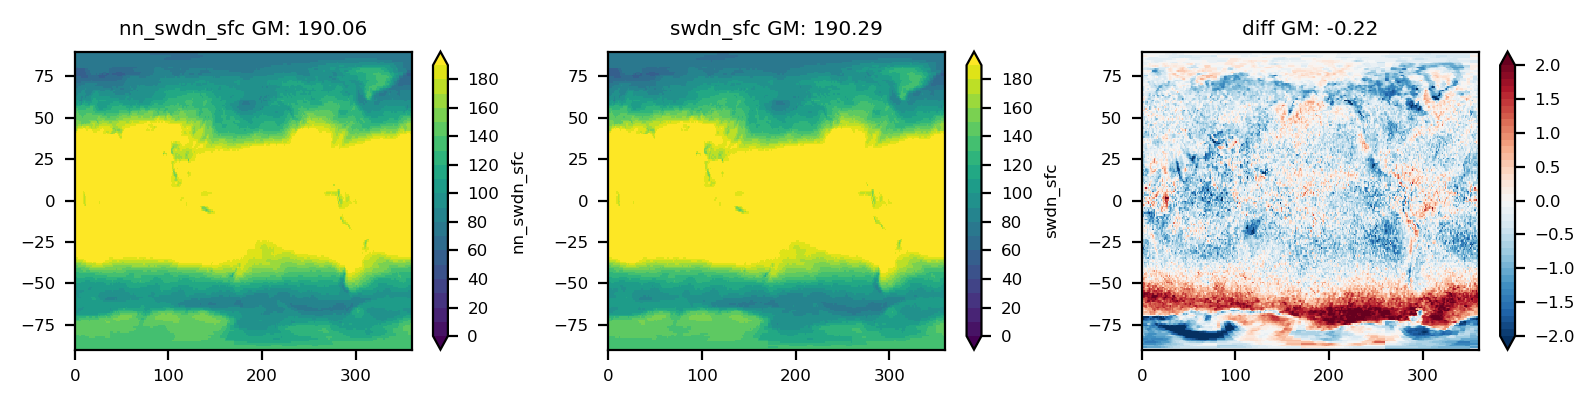

In [8]:
var = ['nn_swdn_sfc_clr','swdn_sfc_clr',]
plot_var12_diff(var,level = np.arange(0,200,10), dlevel = np.arange(-2,2.01,0.1))
var = ['nn_swdn_sfc','swdn_sfc',]
plot_var12_diff(var,level = np.arange(0,200,10), dlevel = np.arange(-2,2.01,0.1))

In [9]:
def plot_var12_diff2(var1,ds_sel,level1=np.arange(-500,1400,100),level2=np.arange(-500,500.1,100)):
    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(8,2),dpi=200)
    axs = axs.flatten() 
    for i in range(3): 
        ax=axs[i] 
        da = ds_sel[var1[0]]
        da.plot.contour(ax=ax, levels=np.arange(-500,1400,500)) 
    for i in range(2):
        ax=axs[i]
        da = ds_sel[var1[i]]
        da.plot(ax=ax, levels=level1, extend='both') 
        ax.set_title(f'{var1[i]} GM: {global_mean_xarray(da).values:4.2f}')  
    ax=axs[2]
    level = level2
    da = (ds_sel[var1[1]]-ds_sel[var1[0]])
    da.plot(ax=ax, levels=level2, extend='both') 
    ax.set_title(f'diff GM: {global_mean_xarray(da).values:4.2f}') 
    for ax in axs:
        ax.set(xlabel=None,ylabel=None)
    fig.tight_layout()  

# Diff in rsdt

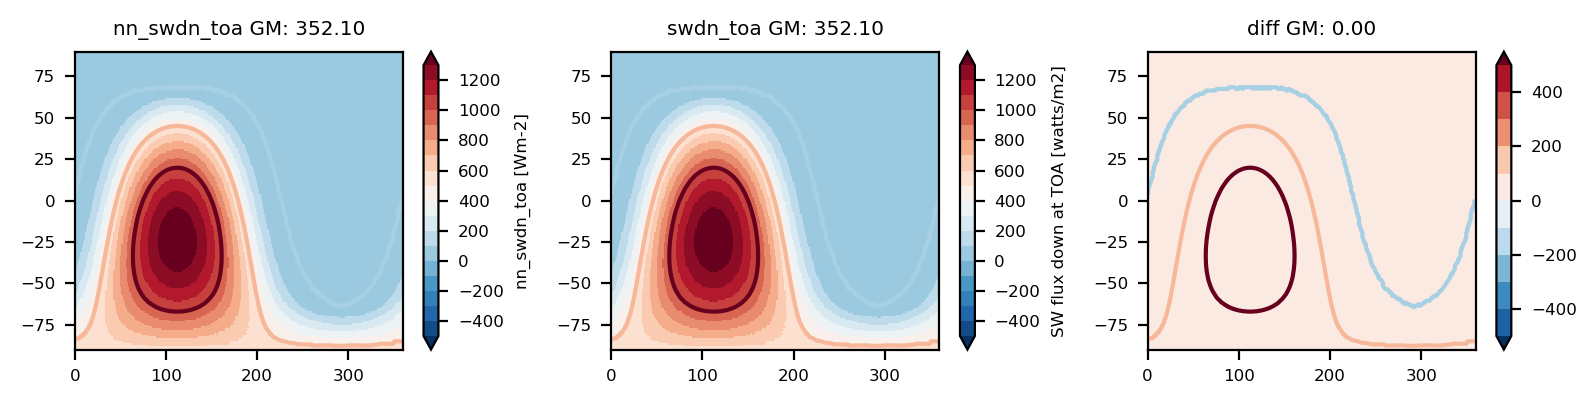

In [10]:
var = ['nn_swdn_toa','swdn_toa',]
# ds_sel = ds.mean('time')
ds_sel = ds.isel(time=0)
plot_var12_diff2(var,ds_sel)

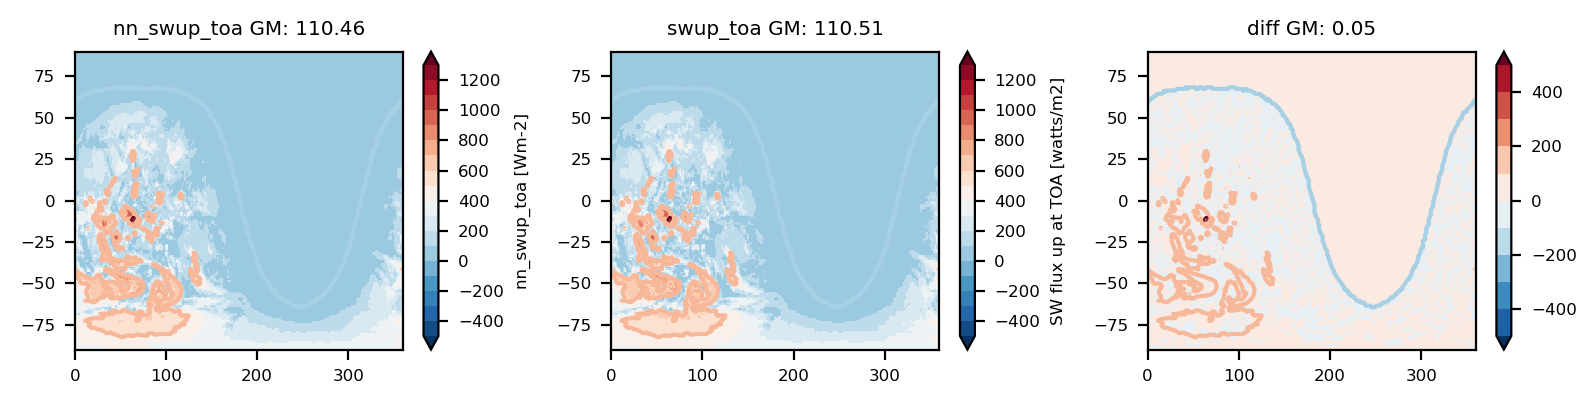

In [11]:
var = ['nn_swup_toa','swup_toa',]
# ds_sel = ds.mean('time')
ds_sel = ds.isel(time=1)
plot_var12_diff2(var,ds_sel)

# Check Error in Energe conservation

## lw

In [12]:

hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
A_k = hybrid_p_sigma_para.ak.values
B_k = hybrid_p_sigma_para.bk.values 
def energy_error_lw_2d(rlut, rlus, rlds, tdt_lw, ps):
    C_p = 1004.64    # J/kg/K 
    g   = 9.8        # m/s^2  
    k = tdt_lw.shape[0]
    nlat = ps.shape[0] 
    P_lev = A_k[:,None,None] + np.matmul(B_k[:,None],ps.reshape(1,-1)).reshape(k+1,nlat,-1)
    dP = (P_lev[1:,:,:] - P_lev[:33,:,:])
    F_net = rlus - rlut - rlds 
    sum_Cphr_gdp = C_p/g * (tdt_lw*dP).sum(axis=0)
    E_err = F_net - sum_Cphr_gdp
    return E_err
def energy_error_sw_2d(rsut, rsdt, rsus, rsds, tdt_sw, ps):
    C_p = 1004.64    # J/kg/K 
    g   = 9.8        # m/s^2  
    k = tdt_lw.shape[0]
    nlat = ps.shape[0] 
    P_lev = A_k[:,None,None] + np.matmul(B_k[:,None],ps.reshape(1,-1)).reshape(k+1,nlat,-1)
    dP = (P_lev[1:,:,:] - P_lev[:33,:,:])
    F_net = rsdt - rsut + rsus - rsds 
    sum_Cphr_gdp = C_p/g * (tdt_sw*dP).sum(axis=0)
    E_err = F_net - sum_Cphr_gdp
    return E_err

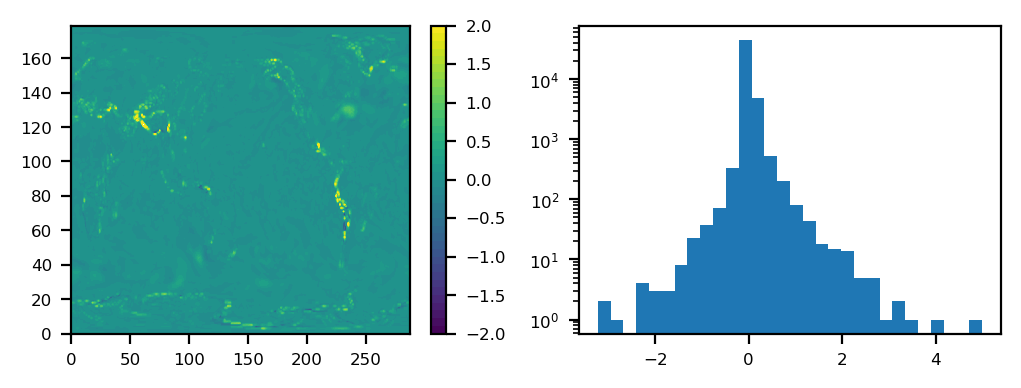

In [13]:
ds_sel = ds.isel(time=[0,1,2,3,4,5,6]).mean('time')
rlut = ds_sel['olr'].values
rlus = ds_sel['lwup_sfc'].values
rlds = ds_sel['lwdn_sfc'].values
tdt_lw = ds_sel['tdt_lw'].values
ps   = ds_sel['nn_plevel'].values[-1,:,:]
eng_err = energy_error_lw_2d(rlut, rlus, rlds, tdt_lw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err,levels = np.arange(-2,2.01,0.1))
# plt.colorbar(ax =axs[0])
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

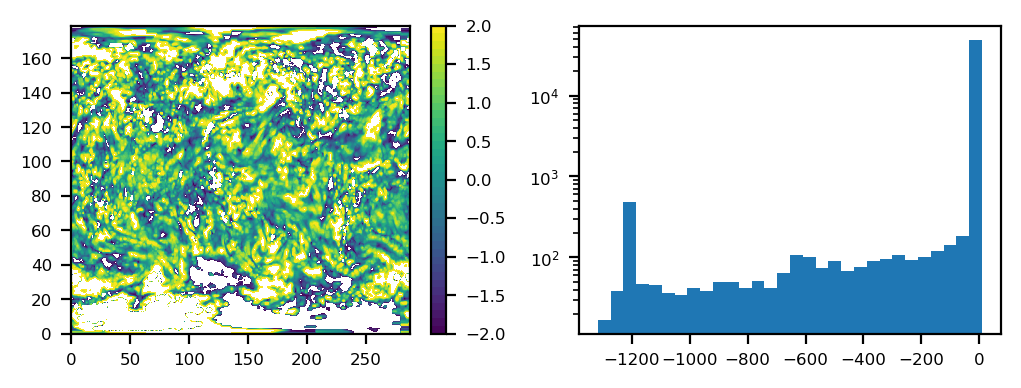

In [14]:
ds_sel = ds.isel(time=[0,1]).mean('time')
rlut = ds_sel['nn_olr_clr'].values
rlus = ds_sel['nn_lwup_sfc'].values
rlds = ds_sel['nn_lwdn_sfc_clr'].values
tdt_lw = ds_sel['nn_tdt_lw_clr'].values
ps   = ds_sel['nn_plevel'].values[-1,:,:]
eng_err = energy_error_lw_2d(rlut, rlus, rlds, tdt_lw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err,levels = np.arange(-2,2.01,0.1))
# plt.colorbar(ax =axs[0])
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

In [15]:
ds_sel['nn_tdt_sw'][:,100,100]

<xarray.DataArray 'nn_tdt_sw' (pfull: 33)>
array([2.4324379e-04, 1.0427993e-04, 7.0871021e-05, 4.8158123e-05,
       3.0759646e-05, 1.9125880e-05, 1.1618711e-05, 6.1679466e-06,
       3.8881217e-06, 3.3811698e-06, 4.3953087e-06, 6.0377170e-06,
       6.5935888e-06, 1.4354599e-05, 9.4746611e-06, 5.7741095e-06,
       8.2861898e-06, 1.2018314e-05, 1.2338756e-05, 1.3689698e-05,
       2.9324980e-05, 4.1720810e-05, 3.9067629e-05, 3.1331736e-05,
       3.0316342e-05, 2.8281567e-05, 2.5805643e-05, 2.4694220e-05,
       2.3679639e-05, 2.2817903e-05, 2.2188558e-05, 2.1834087e-05,
       2.1785287e-05], dtype=float32)
Coordinates:
    lat      float64 10.5
    lon      float64 125.6
  * pfull    (pfull) float64 2.164 5.845 10.75 17.11 ... 975.6 985.4 992.8 997.9

In [16]:
ds_sel['tdt_sw'][:,100,100]

<xarray.DataArray 'tdt_sw' (pfull: 33)>
array([2.4236841e-04, 1.0458358e-04, 7.1937451e-05, 4.8425776e-05,
       3.0881394e-05, 1.8915340e-05, 1.1812272e-05, 6.4093738e-06,
       3.7979871e-06, 3.3796023e-06, 4.4689950e-06, 5.9803929e-06,
       6.4612523e-06, 1.4283817e-05, 9.7926313e-06, 5.6910499e-06,
       8.3464192e-06, 1.1937227e-05, 1.2284072e-05, 1.3412216e-05,
       2.8265164e-05, 3.9576316e-05, 3.7612277e-05, 3.0819236e-05,
       2.8873204e-05, 2.7442587e-05, 2.5805923e-05, 2.5498724e-05,
       2.4296400e-05, 2.3427685e-05, 2.2831591e-05, 2.2484537e-05,
       2.2493125e-05], dtype=float32)
Coordinates:
    lat      float64 10.5
    lon      float64 125.6
  * pfull    (pfull) float64 2.164 5.845 10.75 17.11 ... 975.6 985.4 992.8 997.9

##  sw

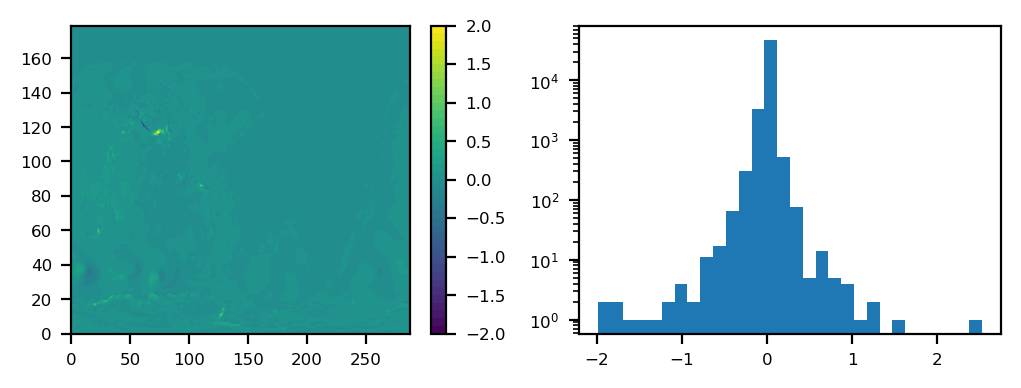

In [17]:
ds_sel = ds.isel(time=[0,1]).mean('time')
rsut = ds_sel['swup_toa'].values
rsdt = ds_sel['swdn_toa'].values
rsus = ds_sel['swup_sfc'].values
rsds = ds_sel['swdn_sfc'].values
tdt_sw = ds_sel['tdt_sw'].values
ps   = ds_sel['ps'].values
eng_err = energy_error_sw_2d(rsut, rsdt, rsus, rsds, tdt_sw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err,levels = np.arange(-2,2.01,0.1))
# plt.colorbar(ax =axs[0])
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

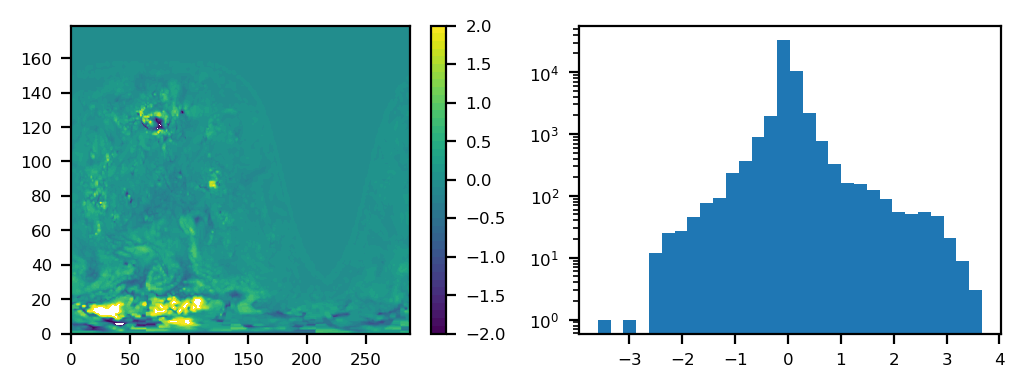

In [18]:
ds_sel = ds.isel(time=[0,1]).mean('time')
rsut = ds_sel['nn_swup_toa'].values
rsdt = ds_sel['nn_swdn_toa'].values
rsus = ds_sel['nn_swup_sfc'].values
rsds = ds_sel['nn_swdn_sfc'].values
tdt_sw = ds_sel['nn_tdt_sw'].values
ps   = ds_sel['ps'].values
eng_err = energy_error_sw_2d(rsut, rsdt, rsus, rsds, tdt_sw, ps)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(6,2),dpi=200)
axs = axs.flatten()
h = axs[0].contourf(eng_err,levels = np.arange(-2,2.01,0.1))
# plt.colorbar(ax =axs[0])
fig.colorbar(h, ax=axs[0])
axs[1].hist(eng_err.flatten(),bins=30)
axs[1].set_yscale('log')
fig.show()

# nn ratio

In [19]:
 
for fi in range(1,7):
    ds = xr.open_dataset(file_path+f'/HISTORY/20000101.atmos_8xdaily.tile{fi}.nc')  
    # ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 

    ds_sel = ds
    data = ds_sel['nn_lwup_sfc'][1200:,:,:].values
    tmp = np.where(data<50, 1, 0 )
    tmp = np.sum(tmp)
    print(tmp, data.size, f'{tmp/data.size*100:5.2f}%')

27546 15925248  0.17%
80293 15925248  0.50%
35671 15925248  0.22%
60201 15925248  0.38%
35214 15925248  0.22%
1018149 15925248  6.39%


In [20]:
 
ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 
ds_sel = ds
data = ds_sel['nn_lwup_sfc'][:24,:,:].values
tmp = np.where(data<50, 1, 0 )
tmp = np.sum(tmp)
print(tmp, data.size, f'{tmp/data.size*100:5.2f}%')

32590 1244160  2.62%


In [21]:
 
for fi in range(1,7):
    ds = xr.open_dataset(file_path+f'/HISTORY/20000101.atmos_8xdaily.tile{fi}.nc')  
    # ds = xr.open_dataset(file_path+'/POSTP/20000101.atmos_8xdaily.nc') 

    ds_sel = ds
    data = ds_sel['nn_lwup_sfc'][:24,:,:].values
    tmp = np.where(data<-100, 1, 0 )
    tmp = np.sum(tmp)
    print(tmp, data.size, f'{tmp/data.size*100:5.2f}%')

209 221184  0.09%
436 221184  0.20%
786 221184  0.36%
434 221184  0.20%
415 221184  0.19%
4375 221184  1.98%
